# В данно ноутбуке представлен пример создания малозатратной и точной сверточной сети с помощью Depthwise Separable Convolution

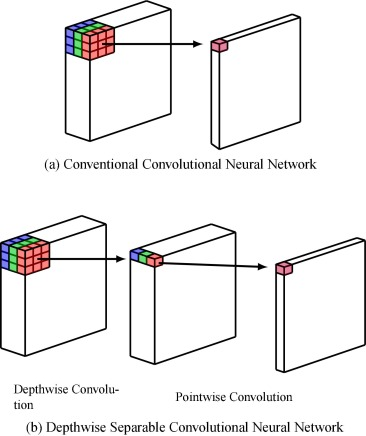

 Depthwise Separable Convolution сначала проивзодит пространственную свертку каждого канала, уменьшая размерность. Полученные "кубики" стоят рядом друг с другом. После чего сверткой 1х1 они смешиваются. В итоге получаем кубик, в три раза меньше исходного.

 Такой процесс добавляет в сеть параметры. И соответственно, делает ее более "умной" и расширяет границы тренировки.
 
 Это эквивалентно разделению пространственных и канальных признаков.

In [1]:
!nvidia-smi

Sat Nov 14 15:28:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Подготовка данных

In [2]:
from keras.datasets import cifar10 as cifar

(x_train, y_train), (x_test, y_test) = cifar.load_data()

170500096/170498071 [==============================] - 5s 0us/step


In [3]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

# преобразование признаков в категориальные (one-hot)
from keras.utils import to_categorical
import matplotlib.pyplot as plt

x_train.astype('float32')
x_val.astype('float32')
x_test.astype('float32')

y_train.astype('float32')
y_val.astype('float32')
y_test.astype('float32')

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(f'x_train shape is {x_train.shape}')
print(f'x_val shape is {x_val.shape}')
print(f'x_test shape is {x_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (35000, 32, 32, 3)
x_val shape is (15000, 32, 32, 3)
x_test shape is (10000, 32, 32, 3)
y_train shape is (35000, 10)
y_val shape is (15000, 10)
y_test shape is (10000, 10)


# Создание модели с обычным сверточным слоем

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 256)        

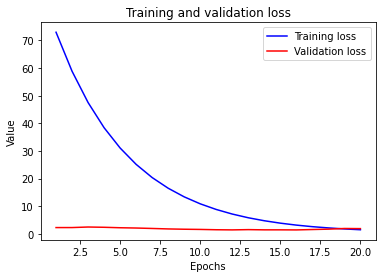

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import keras.regularizers as regularizers

model_1 = Sequential()
x_shape = [32,32,3]

# блок 1
model_1.add(Conv2D(64, (3, 3), padding='same', input_shape=x_shape, activation='relu'))
model_1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# блок 2
model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# блок 3
model_1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# блок 4
model_1.add(Flatten())
model_1.add(Dense(4096, activation='relu'))
model_1.add(Dense(4096, activation='relu'))
model_1.add(Dense(10))
model_1.add(Activation('softmax'))

model_1.summary()

model_1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# ТРЕНИРОВКА
history_1 = model_1.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2
).history

# ОЦЕНКА
(loss_1, accuracy_1) = model_1.evaluate(x_test, y_test, verbose=1)
print(f'Loss is {loss_1}')
print(f'Accuracy is {accuracy_1}')

# ГРАФИКИ
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

def draw_smooth_graph(history):
    loss_values = history["loss"]
    validation_loss_values = history["val_loss"]

    epochs = range(1, len(history['loss']) + 1)

    plt.plot(epochs, smooth_curve(loss_values), 'b', label='Training loss')
    plt.plot(epochs, smooth_curve(validation_loss_values), 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

draw_smooth_graph(history_1)

# Создание модели со слоем раздельной свертки по глубине

(в тренировке больше эпох, так как больше параметров)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_25 (Separab (None, 30, 30, 32)        155       
_________________________________________________________________
separable_conv2d_26 (Separab (None, 28, 28, 64)        2400      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
separable_conv2d_27 (Separab (None, 12, 12, 64)        4736      
_________________________________________________________________
separable_conv2d_28 (Separab (None, 10, 10, 128)       8896      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
separable_conv2d_29 (Separab (None, 3, 3, 64)        

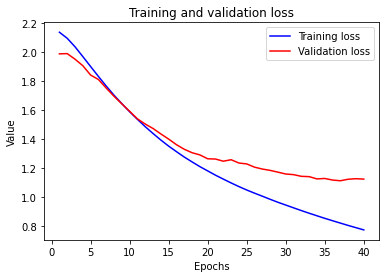

In [13]:
from keras.models import Sequential
from keras.layers import Dense, SeparableConv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
import keras.regularizers as regularizers

model_2 = Sequential()
x_shape = [32,32,3]
num_classes = 10

model_2 = Sequential()
model_2.add(SeparableConv2D(32, 3,activation='relu',input_shape=x_shape))
model_2.add(SeparableConv2D(64, 3, activation='relu'))
model_2.add(MaxPooling2D(2))
model_2.add(SeparableConv2D(64, 3, activation='relu'))
model_2.add(SeparableConv2D(128, 3, activation='relu'))
model_2.add(MaxPooling2D(2))
model_2.add(SeparableConv2D(64, 3, activation='relu'))
model_2.add(SeparableConv2D(128, 3, activation='relu'))
model_2.add(GlobalAveragePooling2D())
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(num_classes, activation='softmax'))
model_2.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model_2.summary()

model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# ТРЕНИРОВКА
history_2 = model_2.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=256,
    validation_split=0.2
).history

# ОЦЕНКА
(loss_2, accuracy_2) = model_2.evaluate(x_test, y_test, verbose=1)
print(f'Loss is {loss_2}')
print(f'Accuracy is {accuracy_2}')

# ГРАФИКИ
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

def draw_smooth_graph(history):
    loss_values = history["loss"]
    validation_loss_values = history["val_loss"]

    epochs = range(1, len(history['loss']) + 1)

    plt.plot(epochs, smooth_curve(loss_values), 'b', label='Training loss')
    plt.plot(epochs, smooth_curve(validation_loss_values), 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

draw_smooth_graph(history_2)

# Сравнение результатов

In [12]:
if accuracy_1 > accuracy_2:
  print(f'model_1 is better - accuracy: {accuracy_1}')
elif acciracy_2 > accuracy_1:
   print(f'model_2 is better - accuracy: {acciracy_2}')

model_1 is better - accuracy: 0.6816999912261963
